# Clustering of Countries Assignment 

### Performed by Rohit Lal

In [1]:
# import required libraries
import pandas as pd
import numpy as np
from random import sample
from numpy.random import uniform
from math import isnan

# import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# import sklearn library
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

# import scipy library
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

# import warning and filtering warnings
import warnings
warnings.filterwarnings('ignore')

# Reading Data

In [2]:
# reading input dataframe
df = pd.read_csv('Country-data.csv')
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


### Converting data from %-age to absolute values

In [3]:
# exports
df.exports = df.exports.div(100) * df.gdpp

# health
df.health = df.health.div(100) * df.gdpp

# imports
df.imports = df.imports.div(100) * df.gdpp

In [4]:
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


In [5]:
# Checking input dataframe info for null values and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


- No missing columns there in the data. No imputation will be required
- No data type correction needed.

In [6]:
# Checking summary of input dataframe
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,7420.618847,1056.733204,6588.352108,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,17973.885795,1801.408906,14710.810418,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,1.076920,12.821200,0.651092,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,447.140000,78.535500,640.215000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,1777.440000,321.886000,2045.580000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,7278.000000,976.940000,7719.600000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,183750.000000,8663.600000,149100.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


# EDA Analysis

### Univariate Analysis

##### Checking distributions in feature variables

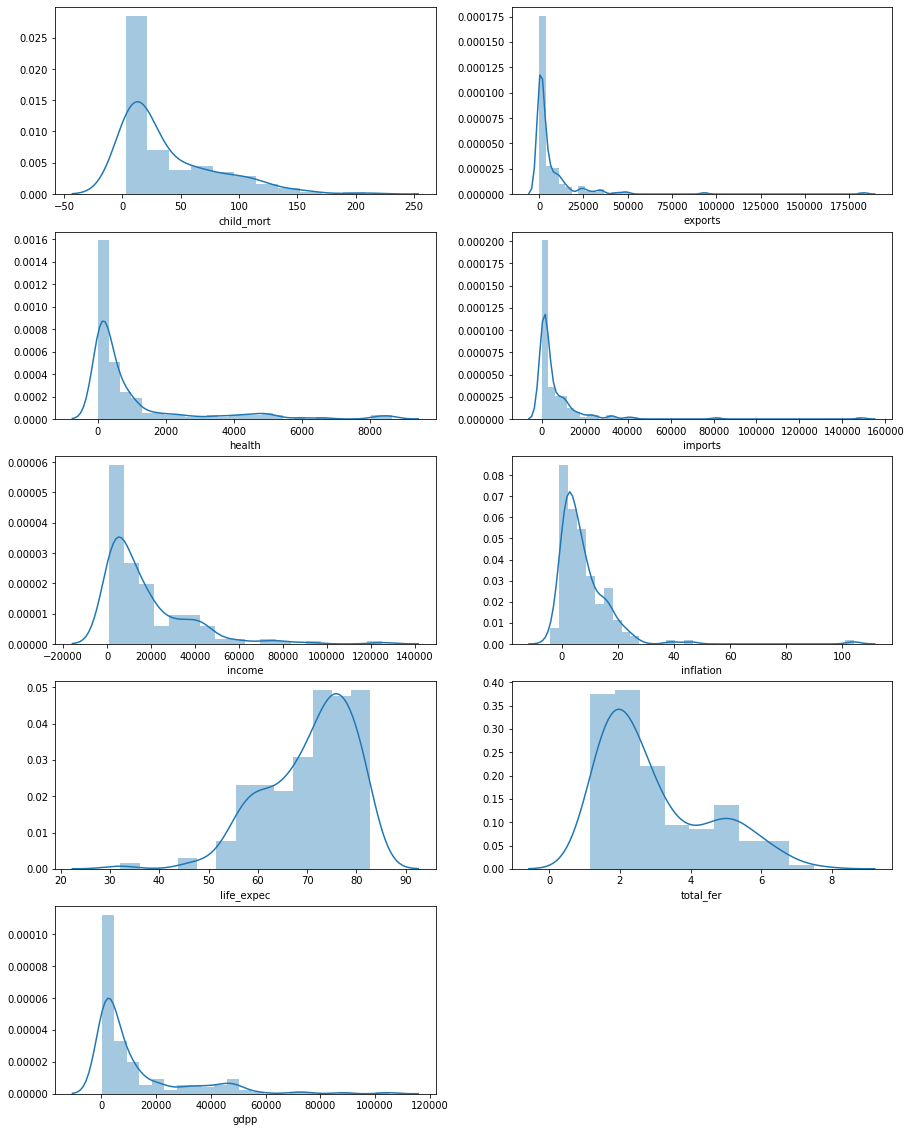

In [7]:
plt.figure(figsize = (15,20))
feature = df.columns[1:]
for i in enumerate(feature):
    plt.subplot(5,2, i[0]+1)
    sns.distplot(df[i[1]])

##### Checking Outliers in feature variables

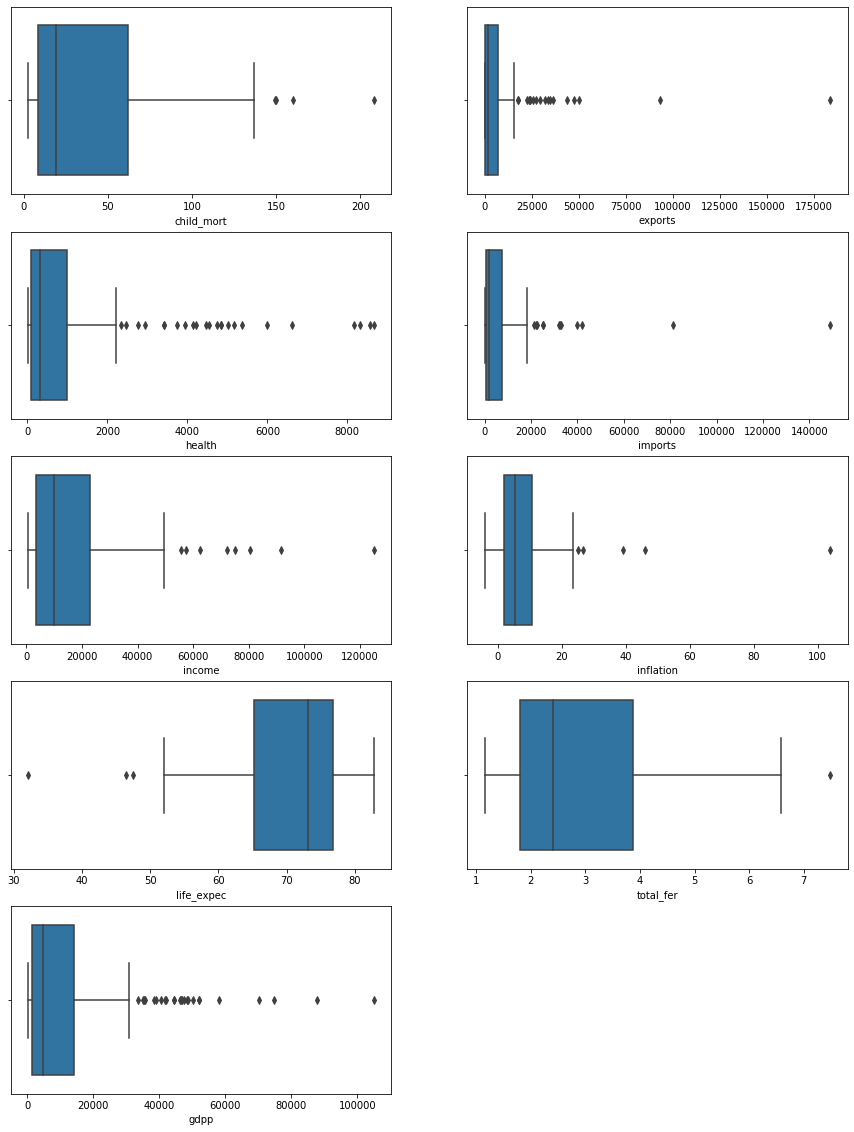

In [8]:
plt.figure(figsize = (15,20))
feature = df.columns[1:]
for i in enumerate(feature):
    plt.subplot(5,2, i[0]+1)
    sns.boxplot(df[i[1]])

- `child_mort` has few outliers on the upper range. We **will not cap** these values, since high child mortality is an important factor in our case.


- `exports` has good number of outliers on the upper range. We **will cap** these outliers for proper clustering.


- `health` has good number of outliers on the upper range. We **will cap** these outliers for proper clustering.


- `imports` also has outliers on the upper range. We **will cap** these outliers for proper clustering.


- `income` also has few outliers on upper range. We **will cap** these outliers for proper clustering.


- `inflation` also has very few outliers on the upper range. We **will not cap** these values, since high inflation is an important factor in our case.


- `life_expec` has very few outliers on the lower range. We **will not cap** these outliers as low life expectancy is import factor in our case.


- `total_fer` has very very few outliers on the upper range. We **will cap** these outliers for proper clustering.


- `gdpp` has good amount of outliers on the higher end. We **will cap** these outliers for proper clustering.

### Multi-variate Analysis

In [9]:
def scatter_plot(df, x_col, y_col, x_label, y_label):

    plt.figure(figsize = (9, 6))

    sns.scatterplot(x=x_col, y=y_col, data=df);
    plt.title('{} vs {}'.format(x_label, y_label), fontsize=18)
    plt.xlabel(x_label, fontsize=15)
    plt.ylabel(y_label, fontsize=15)

    plt.show()

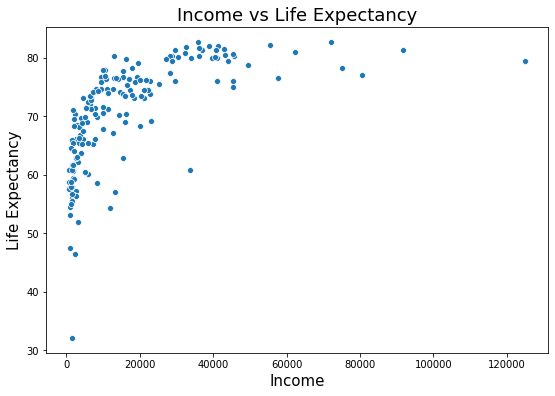

In [10]:
# Plotting Income v/s life expectancy
scatter_plot(df, x_col='income', y_col='life_expec', x_label="Income", y_label="Life Expectancy")

- We can infer that, the `life expectancy` is higer in high `income` countries.

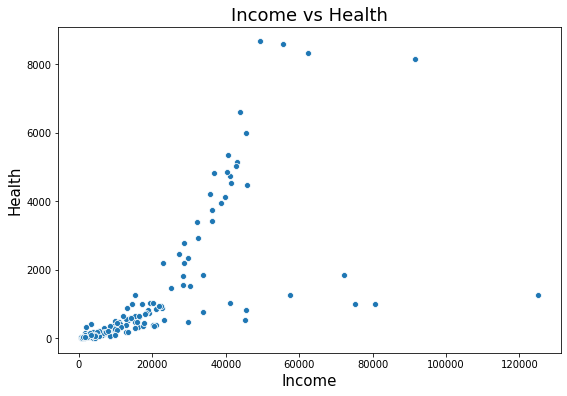

In [11]:
# Plotting Income v/s Health
scatter_plot(df, x_col='income', y_col='health', x_label="Income", y_label="Health")

- `Health` is in general better for high income.

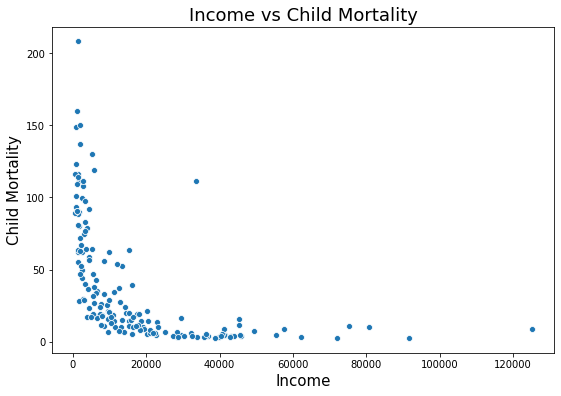

In [12]:
# Plotting Income v/s Child Mortality
scatter_plot(df, x_col='income', y_col='child_mort', x_label="Income", y_label="Child Mortality")

- `Child mortality` decreases as the `Income` increases

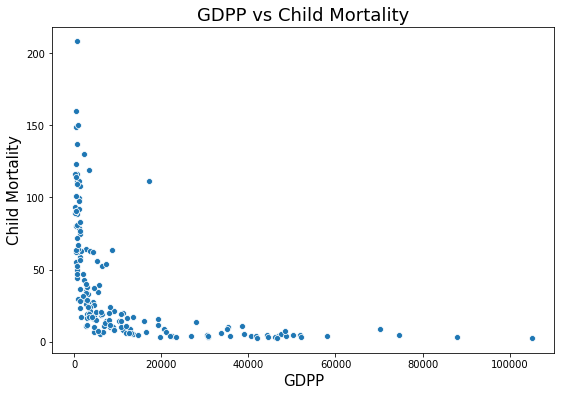

In [13]:
# Plotting GDPP v/s Child Mortality
scatter_plot(df, x_col='gdpp', y_col='child_mort', x_label="GDPP", y_label="Child Mortality")

- `Child mortality` rate decrease substantially for higher GDPP countries.

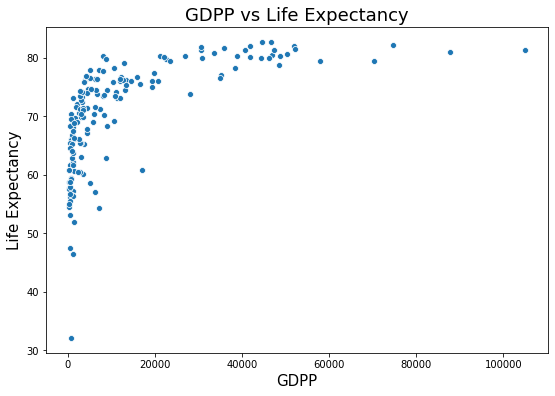

In [14]:
# Plotting GDPP v/s Life Expectancy
scatter_plot(df, x_col='gdpp', y_col='life_expec', x_label="GDPP", y_label="Life Expectancy")

- `Life Expectancy` is higher for high `GDPP` countries.

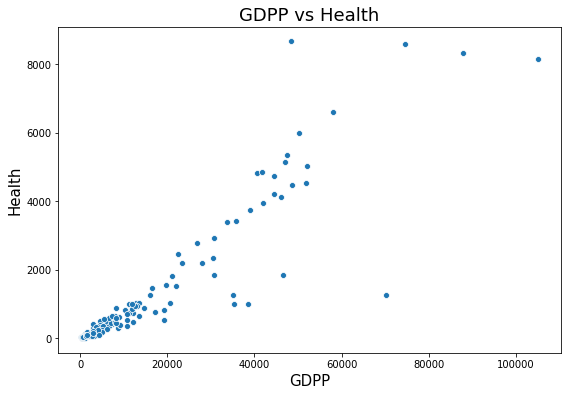

In [15]:
# Plotting GDPP v/s Health
scatter_plot(df, x_col='gdpp', y_col='health', x_label="GDPP", y_label="Health")

- `Health` is in general better for high `GDP` countries.

In [16]:
def bar_plot(df, x_col, y_col, x_label, y_label):

    plt.figure(figsize = (9, 6))

    sns.barplot(x=x_col, y=y_col, data=df)
    plt.title('{} vs {}'.format(x_label, y_label), fontsize=18)
    plt.xlabel(x_label, fontsize=15)
    plt.ylabel(y_label, fontsize=15)

    plt.show()

##### Top 10 countries with highest child mortality

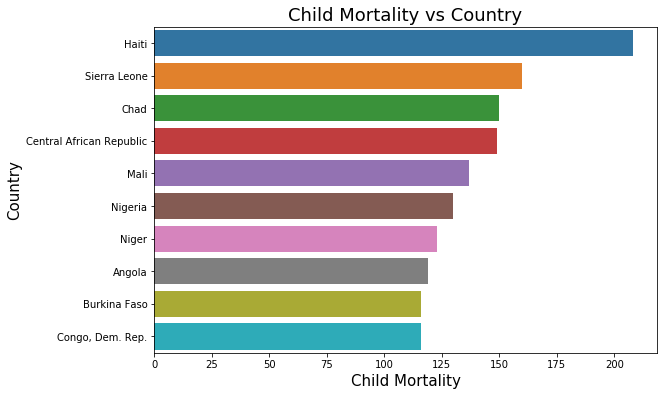

In [17]:
bar_plot(df=df.sort_values(by='child_mort', ascending=False).head(10), 
        x_col='child_mort', y_col='country', x_label='Child Mortality', y_label='Country')

##### Top 10 countries with lowest health index

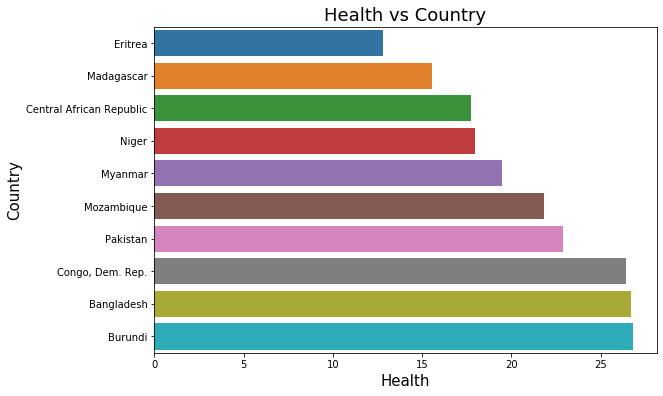

In [18]:
bar_plot(df=df.sort_values(by='health', ascending=True).head(10), 
        x_col='health', y_col='country', x_label='Health', y_label='Country')

##### Top 10 countries with highest inflation rate

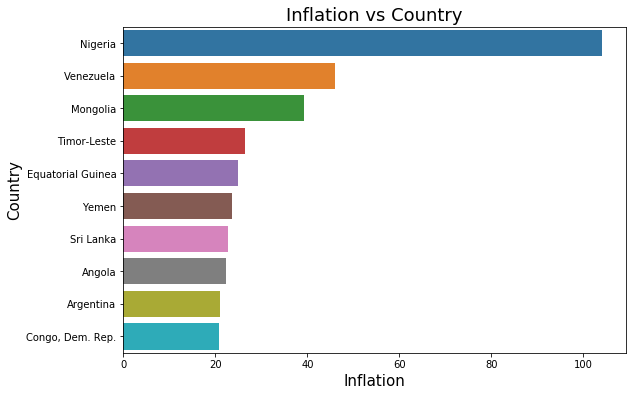

In [19]:
bar_plot(df=df.sort_values(by='inflation', ascending=False).head(10), 
        x_col='inflation', y_col='country', x_label='Inflation', y_label='Country')

##### Top 10 countries with lowest life expectancy

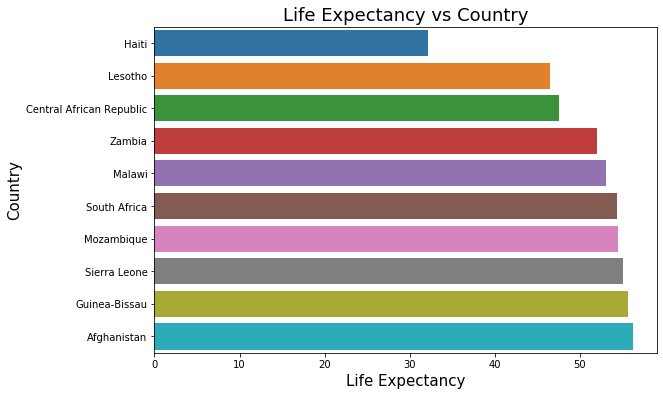

In [20]:
bar_plot(df=df.sort_values(by='life_expec', ascending=True).head(10), 
        x_col='life_expec', y_col='country', x_label='Life Expectancy', y_label='Country')

##### Top 10 countries with lowest gdpp

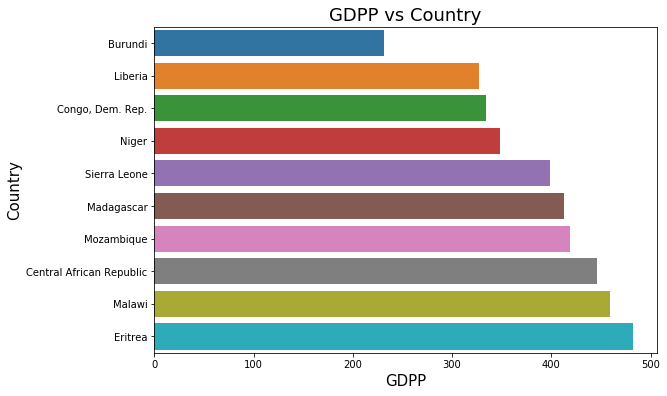

In [21]:
bar_plot(df=df.sort_values(by='gdpp', ascending=True).head(10), 
        x_col='gdpp', y_col='country', x_label='GDPP', y_label='Country')

##### Top 10 countries with lowest income

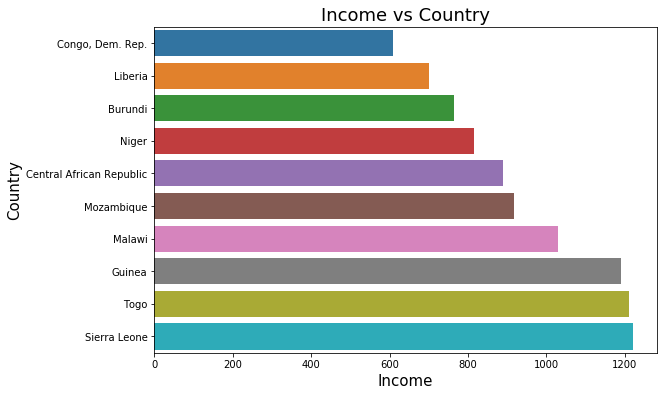

In [22]:
bar_plot(df=df.sort_values(by='income', ascending=True).head(10), 
        x_col='income', y_col='country', x_label='Income', y_label='Country')

### Outlier Treatment - Capping the outliers

In [23]:
def cap_column(df, col_name, cap_lower=False, cap_upper=False):

    q1 = df[col_name].quantile(0.01)
    q4 = df[col_name].quantile(0.99)
    
    if cap_lower:
        df[col_name][df[col_name]<= q1] = q1
    
    if cap_upper:
        df[col_name][df[col_name]>= q4] = q4

    return df

In [24]:
# capping exports column
df = cap_column(df, 'exports', cap_upper=True)

In [25]:
# capping health column
df = cap_column(df, 'health', cap_upper=True)

In [26]:
# capping imports column
df = cap_column(df, 'imports', cap_upper=True)

In [27]:
# capping income column
df = cap_column(df, 'income', cap_upper=True)

In [28]:
# capping total_fer column
df = cap_column(df, 'total_fer', cap_upper=True)

In [29]:
# capping gdpp column
df = cap_column(df, 'gdpp', cap_upper=True)

## Clustering

In [30]:
#Calculating the Hopkins statistic
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [31]:
hopkins(df.drop('country', axis = 1))

0.9265489809009795

In [32]:
# Caculating average of 10 runs of hopkins statistics
hopkins_avg = 0
for i in range(10):
    hopkins_avg += hopkins(df.drop('country', axis = 1))
    
print(hopkins_avg/10)

0.897779810810035


## Scaling

In [33]:
# Scaling the dataset using standard scalar
scaler = StandardScaler()
df_scaled_array = scaler.fit_transform(df.drop('country', axis = 1))
df_scaled_array

array([[ 1.29153238, -0.56962212, -0.56695778, ..., -1.61909203,
         1.92639646, -0.70225949],
       [-0.5389489 , -0.47385792, -0.4403934 , ...,  0.64786643,
        -0.86505432, -0.49872564],
       [-0.27283273, -0.42399973, -0.48627082, ...,  0.67042323,
        -0.03498262, -0.47743428],
       ...,
       [-0.37231541, -0.49160668, -0.54024972, ...,  0.28695762,
        -0.66423052, -0.65869853],
       [ 0.44841668, -0.53995007, -0.55242911, ..., -0.34463279,
         1.15657191, -0.65869853],
       [ 1.11495062, -0.52701632, -0.54227159, ..., -2.09278484,
         1.64524315, -0.6500669 ]])

In [34]:
df_scaled = pd.DataFrame(df_scaled_array, columns = df.columns[1:])
df_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291532,-0.569622,-0.566958,-0.598741,-0.851668,0.157336,-1.619092,1.926396,-0.702259
1,-0.538949,-0.473858,-0.440393,-0.413584,-0.386946,-0.312347,0.647866,-0.865054,-0.498726
2,-0.272833,-0.424000,-0.486271,-0.476100,-0.221053,0.789274,0.670423,-0.034983,-0.477434
3,2.007808,-0.381249,-0.534088,-0.463973,-0.612045,1.387054,-1.179234,2.153997,-0.530950
4,-0.695634,-0.086742,-0.178410,0.139728,0.125254,-0.601749,0.704258,-0.543736,-0.032042


## K-Mean Clustering

##### Choosing the value of K

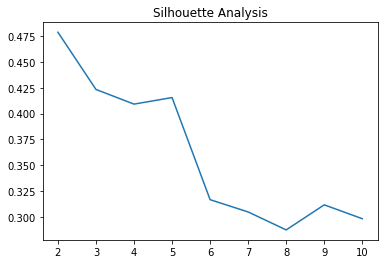

In [35]:
# silhouette score
ss = []
for k in range(2, 11):
    kmean = KMeans(n_clusters = k).fit(df_scaled)
    ss.append([k, silhouette_score(df_scaled, kmean.labels_)])
temp = pd.DataFrame(ss)    
plt.plot(temp[0], temp[1])
plt.title("Silhouette Analysis")
plt.show()

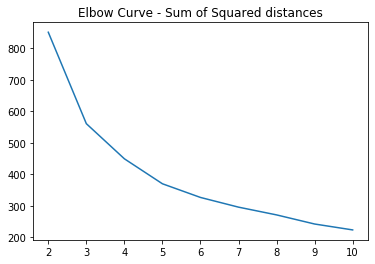

In [36]:
# Elbow curve-ssd
ssd = []
for k in range(2, 11):
    kmean = KMeans(n_clusters = k).fit(df_scaled)
    ssd.append([k, kmean.inertia_])
    
temp = pd.DataFrame(ssd)
plt.plot(temp[0], temp[1])
plt.title("Elbow Curve - Sum of Squared distances")
plt.show()

- `K = 3` looks good in our case, from above elbow-curve and silhouette score
- `K = 3` has high silhouette score

- Let us try with both K=5 and K=3 and find out which one is better.

In [37]:
# defining function for visualizing the clusters
def scatter_plot(df, x_col, y_col, hue_col, x_label, y_label):

    plt.figure(figsize = (9, 6))
    sns.scatterplot(x=x_col, y=y_col, hue=hue_col, data=df, palette='Set1')
    plt.title('{} vs {}'.format(x_label, y_label), fontsize=18)
    plt.xlabel(x_label, fontsize=15)
    plt.ylabel(y_label, fontsize=15)
    plt.show()

#### Choosing K = 5

In [38]:
# Applying K-mean Clustering with K = 5
kmean = KMeans(n_clusters = 5, random_state = 50)
kmean.fit(df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=50, tol=0.0001, verbose=0)

In [39]:
df_kmean = df.copy()

In [40]:
# Getting labels after k-mean clustering 
label  = pd.DataFrame(kmean.labels_, columns= ['label'])
label.head()

,label
0,3
1,0
2,0
3,3
4,0


In [41]:
# Adding labels to the data frame
df_kmean = pd.concat([df_kmean, label], axis =1)
df_kmean.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,3
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,0
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,0
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,3
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,0


In [42]:
# Checking number of entries in each cluster
df_kmean.label.value_counts()

0    81
3    47
4    29
1     9
2     1
Name: label, dtype: int64

- We can see the Cluster2 has only single element in it. This shows that the value of K chosen is not appropriate.

### Plotting the Clusters

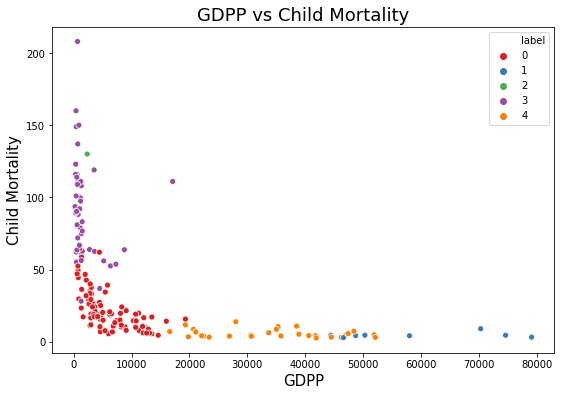

In [43]:
# Plotting the cluster chart between gdpp and child mortality
scatter_plot(df_kmean, x_col='gdpp', y_col='child_mort', hue_col='label', x_label='GDPP', y_label='Child Mortality')

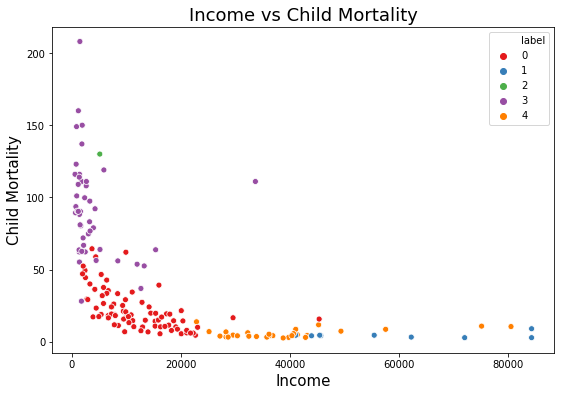

In [44]:
# Plotting the cluster chart between income and child mortality
scatter_plot(df_kmean, x_col='income', y_col='child_mort', hue_col='label', x_label='Income', y_label='Child Mortality')

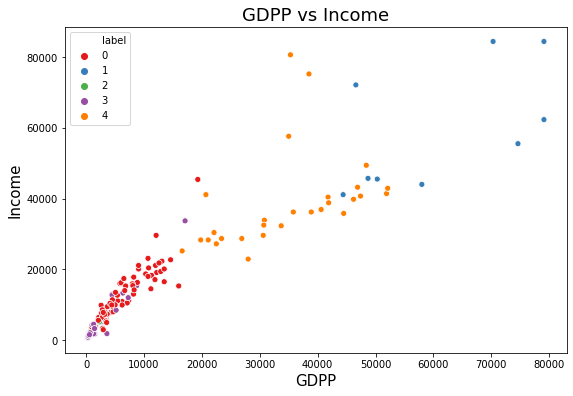

In [45]:
# Plotting the cluster chart between gdpp and income
scatter_plot(df_kmean, x_col='gdpp', y_col='income', hue_col='label', x_label='GDPP', y_label='Income')

- We can see the choice of value of `K=5` is not appropriate, since the `cluster-2` has only single element. 
- Having a single element in a cluster indicates that the choice of number of clusters is not appropriate.


- We will choose the value of `K=3`

#### Choosing K=3

In [46]:
# Applying K-mean Clustering with K = 3
kmean = KMeans(n_clusters = 3, random_state = 50)
kmean.fit(df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=50, tol=0.0001, verbose=0)

In [47]:
df_kmean = df.copy()

In [48]:
# Getting labels after k-mean clustering 
label  = pd.DataFrame(kmean.labels_, columns= ['label'])
label.head()

,label
0,2
1,0
2,0
3,2
4,0


In [49]:
# Adding labels to the data frame
df_kmean = pd.concat([df_kmean, label], axis =1)
df_kmean.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,2
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,0
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,0
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,2
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,0


In [50]:
# Checking number of entries in each cluster
df_kmean.label.value_counts()

0    92
2    48
1    27
Name: label, dtype: int64

### Plotting the Clusters

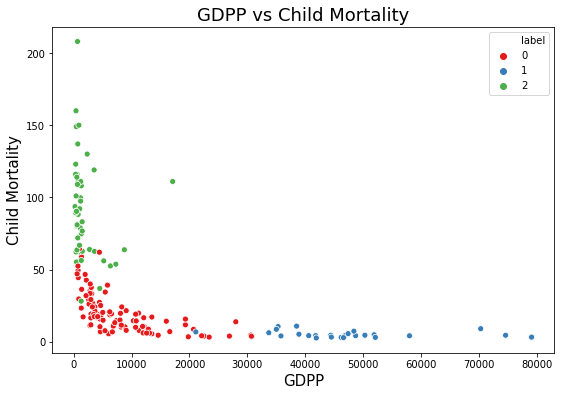

In [51]:
# Plotting the cluster chart between gdpp and child mortality
scatter_plot(df_kmean, x_col='gdpp', y_col='child_mort', hue_col='label', x_label='GDPP', y_label='Child Mortality')

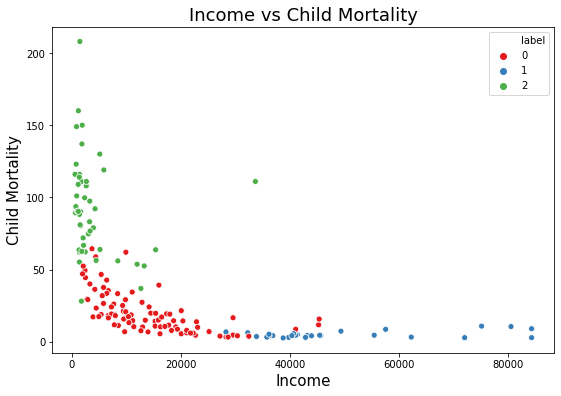

In [52]:
# Plotting the cluster chart between income and child mortality
scatter_plot(df_kmean, x_col='income', y_col='child_mort', hue_col='label', x_label='Income', y_label='Child Mortality')

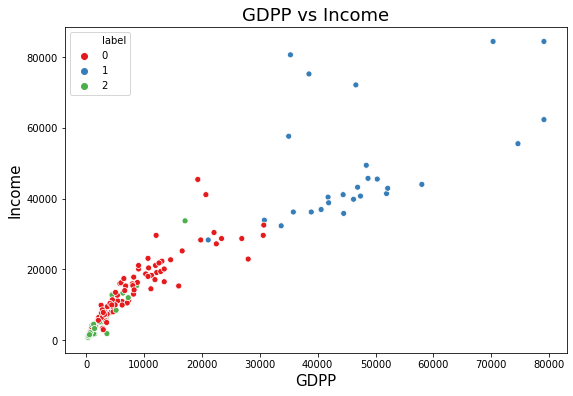

In [53]:
# Plotting the cluster chart between gdpp and income
scatter_plot(df_kmean, x_col='gdpp', y_col='income', hue_col='label', x_label='GDPP', y_label='Income')

## Cluster Profiling

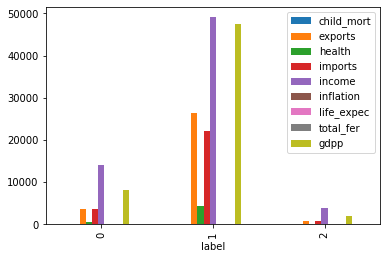

In [54]:
# Checking variation of features across clusters
df_kmean.drop('country', axis = 1).groupby('label').mean().plot(kind = 'bar')
plt.show()

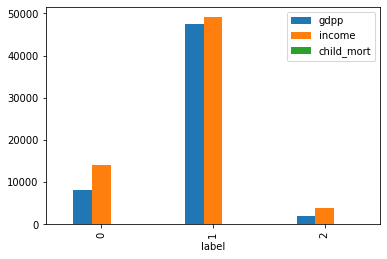

In [55]:
# Checking variation of 'income', 'child_mort', 'gdpp'
df_kmean[['gdpp', 'income', 'child_mort', 'label']].groupby('label').mean().plot(kind = 'bar')
plt.show()

##### Low income, Low GDP and High Child_mort

- Cluster 2 satisfies the above condition

In [56]:
df_kmean[df_kmean['label'] == 2].head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
0,Afghanistan,90.2,55.300,41.9174,248.297,1610.0,9.440,56.2,5.82,553.0,2
3,Angola,119.0,2199.190,100.6050,1514.370,5900.0,22.400,60.1,6.16,3530.0,2
17,Benin,111.0,180.404,31.0780,281.976,1820.0,0.885,61.8,5.36,758.0,2
21,Botswana,52.5,2768.600,527.0500,3257.550,13300.0,8.920,57.1,2.88,6350.0,2
25,Burkina Faso,116.0,110.400,38.7550,170.200,1430.0,6.810,57.9,5.87,575.0,2


##### Top 5 countries fulfilling the -- Low income, Low GDPP, High child mortality criteria

In [57]:
df_kmean[df_kmean['label'] == 2].sort_values(by = ['gdpp', 'income', 'child_mort'], ascending = [True, True, False]).head(5)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
26,Burundi,93.6,20.6052,26.7960,90.552,764.0,12.30,57.7,6.2600,231.0,2
88,Liberia,89.3,62.4570,38.5860,302.802,700.0,5.47,60.8,5.0200,327.0,2
37,"Congo, Dem. Rep.",116.0,137.2740,26.4194,165.664,609.0,20.80,57.5,6.5400,334.0,2
112,Niger,123.0,77.2560,17.9568,170.868,814.0,2.55,58.8,6.5636,348.0,2
132,Sierra Leone,160.0,67.0320,52.2690,137.655,1220.0,17.20,55.0,5.2000,399.0,2


- **`Burundi`, `Liberia`, `Congo, Dem. Rep.`, `Niger`, `Sierra Leone` are the countries having low income, low gdpp and high child mortality.**

## Heirarchical Clustering

In [58]:
# Scaled data frame
df_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291532,-0.569622,-0.566958,-0.598741,-0.851668,0.157336,-1.619092,1.926396,-0.702259
1,-0.538949,-0.473858,-0.440393,-0.413584,-0.386946,-0.312347,0.647866,-0.865054,-0.498726
2,-0.272833,-0.424000,-0.486271,-0.476100,-0.221053,0.789274,0.670423,-0.034983,-0.477434
3,2.007808,-0.381249,-0.534088,-0.463973,-0.612045,1.387054,-1.179234,2.153997,-0.530950
4,-0.695634,-0.086742,-0.178410,0.139728,0.125254,-0.601749,0.704258,-0.543736,-0.032042


In [59]:
# Data frame with labes from k-mean
df_kmean.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,2
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,0
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,0
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,2
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,0


##### Single Linkage

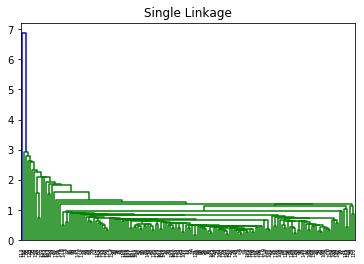

In [60]:
mergings = linkage(df_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.title("Single Linkage")
plt.show()

##### Complete Linkage

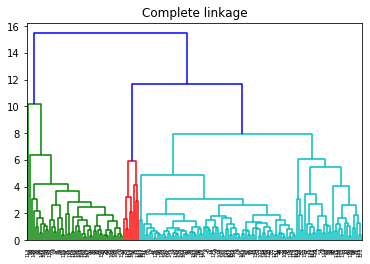

In [61]:
mergings = linkage(df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.title("Complete linkage")
plt.show()

- `Complete linkage` is more interpretable as compared to the `Single linkage`.

- We chose `n=3` for cutting the dendrogram

In [62]:
# Cutting the dendogram for 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       2, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 2, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       2, 1, 0, 0, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 2, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 2, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0])

In [63]:
# assign cluster labels
df_kmean['hcluster_labels'] = cluster_labels
df_kmean.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label,hcluster_labels
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,2,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,0,1
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,0,1
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,2,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,0,1


##### Now plotting the features across the new labels

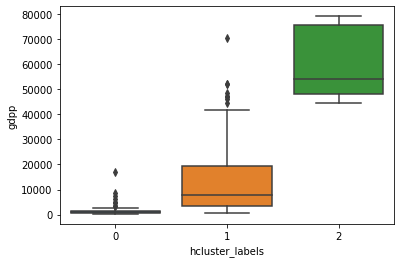

In [64]:
# Plotting gdpp across cluster labels
sns.boxplot(x='hcluster_labels', y='gdpp', data=df_kmean)
plt.show()

- `Cluster-2` has highest `gdpp` followed by `Cluster-1` and `Cluster-0`

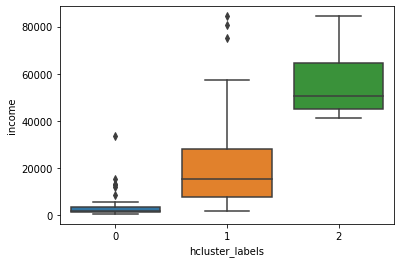

In [65]:
# Plotting income across cluster labels
sns.boxplot(x='hcluster_labels', y='income', data=df_kmean)
plt.show()

- `Cluster-2` has highest `income` followed by `Cluster-1` and `Cluster-0`

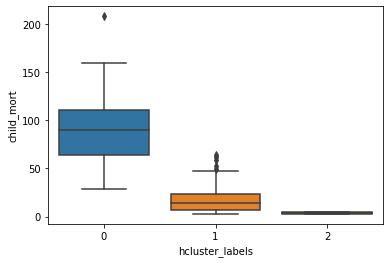

In [66]:
# Plotting child_mort across cluster labels
sns.boxplot(x='hcluster_labels', y='child_mort', data=df_kmean)
plt.show()

- `Cluster-2` has lowest `child mortality` followed by `Cluster-1` and `Cluster-0`

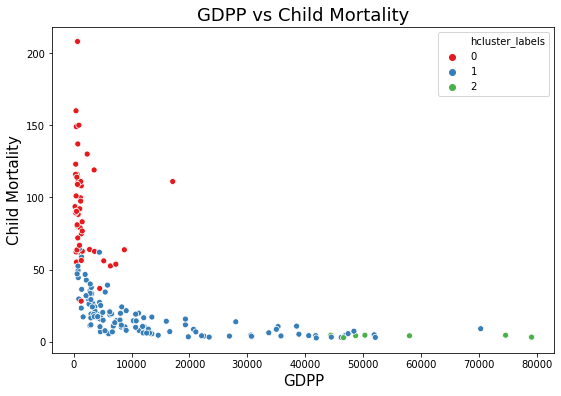

In [67]:
# Plotting the cluster chart between gdpp and child mortality
scatter_plot(df_kmean, x_col='gdpp', y_col='child_mort', hue_col='hcluster_labels', x_label='GDPP', y_label='Child Mortality')

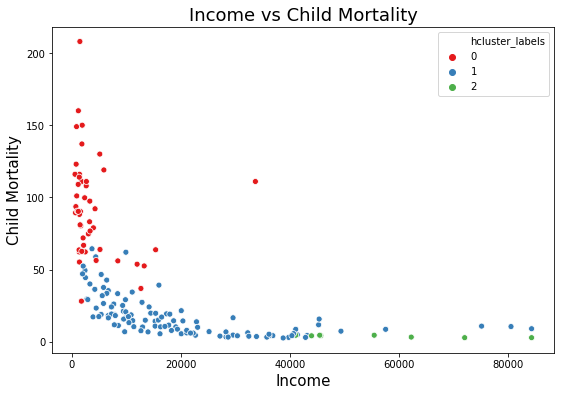

In [68]:
# Plotting the cluster chart between income and child mortality
scatter_plot(df_kmean, x_col='income', y_col='child_mort', hue_col='hcluster_labels', x_label='Income', y_label='Child Mortality')

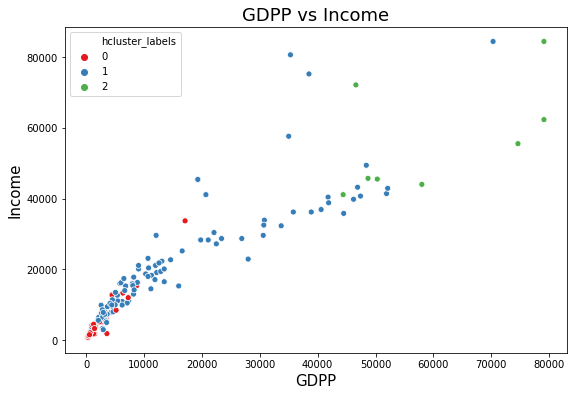

In [69]:
# Plotting the cluster chart between gdpp and income
scatter_plot(df_kmean, x_col='gdpp', y_col='income', hue_col='hcluster_labels', x_label='GDPP', y_label='Income')

## Cluster Profiling

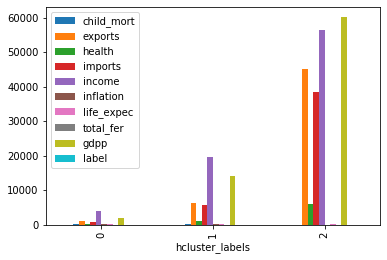

In [70]:
# Checking variation of features across clusters given by hierarchical clustering
df_kmean.drop('country', axis = 1).groupby('hcluster_labels').mean().plot(kind = 'bar')

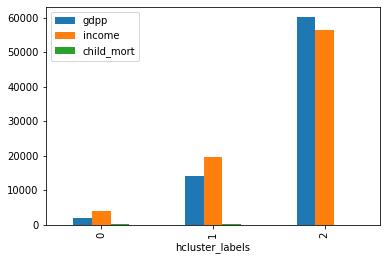

In [71]:
# Checking variation of 'income', 'child_mort', 'gdpp'
df_kmean[['gdpp', 'income', 'child_mort', 'hcluster_labels']].groupby('hcluster_labels').mean().plot(kind = 'bar')

##### Low income, Low GDP and High Child_mort

- Cluster 0 fits the above condition

In [72]:
df_kmean[df_kmean['hcluster_labels'] == 0].head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label,hcluster_labels
0,Afghanistan,90.2,55.300,41.9174,248.297,1610.0,9.440,56.2,5.82,553.0,2,0
3,Angola,119.0,2199.190,100.6050,1514.370,5900.0,22.400,60.1,6.16,3530.0,2,0
17,Benin,111.0,180.404,31.0780,281.976,1820.0,0.885,61.8,5.36,758.0,2,0
21,Botswana,52.5,2768.600,527.0500,3257.550,13300.0,8.920,57.1,2.88,6350.0,2,0
25,Burkina Faso,116.0,110.400,38.7550,170.200,1430.0,6.810,57.9,5.87,575.0,2,0


In [73]:
# Top 5 countries full filling the -- Low income, Low GDPP, High child mortality criteria
df_kmean[df_kmean['hcluster_labels'] == 0].sort_values(by = ['gdpp', 'income', 'child_mort'], ascending = [True, True, False]).head(5)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label,hcluster_labels
26,Burundi,93.6,20.6052,26.7960,90.552,764.0,12.30,57.7,6.2600,231.0,2,0
88,Liberia,89.3,62.4570,38.5860,302.802,700.0,5.47,60.8,5.0200,327.0,2,0
37,"Congo, Dem. Rep.",116.0,137.2740,26.4194,165.664,609.0,20.80,57.5,6.5400,334.0,2,0
112,Niger,123.0,77.2560,17.9568,170.868,814.0,2.55,58.8,6.5636,348.0,2,0
132,Sierra Leone,160.0,67.0320,52.2690,137.655,1220.0,17.20,55.0,5.2000,399.0,2,0


- **`Burundi`, `Liberia`, `Congo, Dem. Rep.`, `Niger`, `Sierra Leone` are the countries having low income, low gdpp and high child mortality.**

We can see the clustering results from the `K-Means clustering` and `Heirarchical clustering` turns out to be similar.

Hence, top 5 countries that requires aid are - 

- **`Burundi`**
- **`Liberia`**
- **`Congo, Dem. Rep.`**
- **`Niger`**
- **`Sierra Leone`**